# Fuzzing with Input Fragments

In this chapter, we introduce how to combine [parsing](Parser.ipynb) and [fuzzing](GrammarFuzzer.ipynb).  This allows to _mutate_ existing inputs while preserving syntactical correctness, and to _reuse_ fragments from existing inputs while generating new ones.  The combination of parsing and fuzzing, as demonstrated in this chapter, has been highly successful in practice: The _LangFuzz_ fuzzer for JavaScript has found more than 2,600 bugs in JavaScript interpreters this way.

**Prerequisites**

* You should know [how to use a parser](Parser.ipynb).
* You should have read the [chapter on efficient grammar fuzzing](GrammarFuzzer.ipynb).

In [1]:
import fuzzingbook_utils

In [2]:
from Parser import PEGParser
from GrammarFuzzer import GrammarFuzzer

## Recombining Parsed Inputs

Recombining parsed inputs was pioneered by _Langfuzz_ \cite{Holler2012}. The main challenge is that program inputs often carry additional constraints beyond what is described by the syntax. For example, in Java, one needs to declare a variable (using a specific format for declaration) before it can be used in an expression. This restriction is not captured in the _Java CFG_. Checking for type correctness is another example for additional restrictions carried by program definitions.

When fuzzing compilers and interpreters, naive generation of programs using the language *CFG* often fails to achieve significant deeper coverage due to these kinds of checks external to the grammar. Holler et al. suggests using pre-existing valid code fragments to get around these restrictions. The idea is that the pre-existing valid code fragments already conform to the restrictions external to the grammar, and can often provide a means to evade validity checks.

### A Grammar-based Mutational Fuzzer

The idea is that one can treat the derivation tree of a preexisting program as the scaffolding, poke holes in it, and patch it with generated inputs from our grammar. Given below is a grammar for a language that allows assignment of variables.

In [3]:
import string

In [4]:
from Grammars import crange, syntax_diagram

In [5]:
VAR_GRAMMAR = {
    '<start>': ['<statements>'],
    '<statements>': ['<statement>;<statements>', '<statement>'],
    '<statement>': ['<assignment>'],
    '<assignment>': ['<identifier>=<expr>'],
    '<identifier>': ['<word>'],
    '<word>': ['<alpha><word>', '<alpha>'],
    '<alpha>': list(string.ascii_letters),
    '<expr>': ['<term>+<expr>', '<term>-<expr>', '<term>'],
    '<term>': ['<factor>*<term>', '<factor>/<term>', '<factor>'],
    '<factor>':
    ['+<factor>', '-<factor>', '(<expr>)', '<identifier>', '<number>'],
    '<number>': ['<integer>.<integer>', '<integer>'],
    '<integer>': ['<digit><integer>', '<digit>'],
    '<digit>': crange('0', '9')
}

start


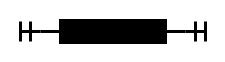

statements


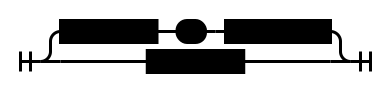

statement


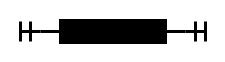

assignment


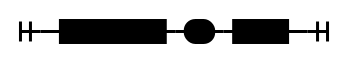

identifier


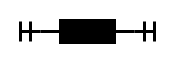

word


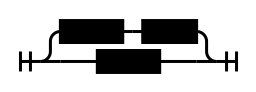

alpha


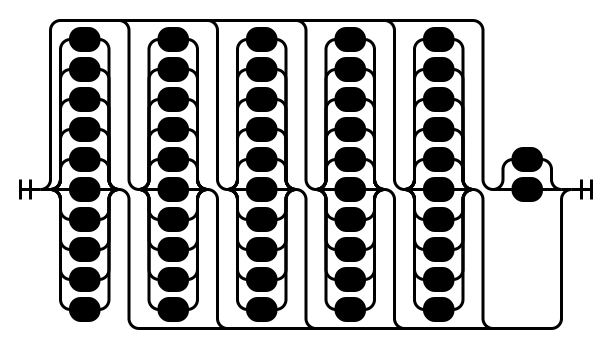

expr


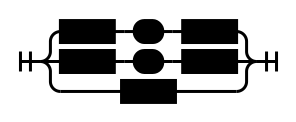

term


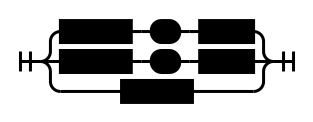

factor


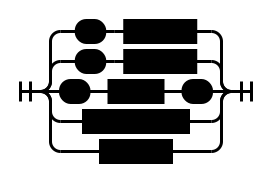

number


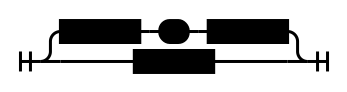

integer


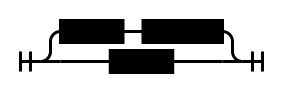

digit


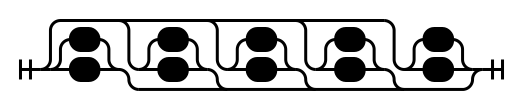

In [6]:
syntax_diagram(VAR_GRAMMAR)

Let us use our new grammar to parse a program.

In [7]:
mystring = 'va=10;vb=20'

In [8]:
def hl_predicate(_d, _n, symbol, _a): return symbol in {
    '<number>', '<identifier>'}

In [9]:
from Parser import PEGParser, highlight_node
from GrammarFuzzer import display_tree

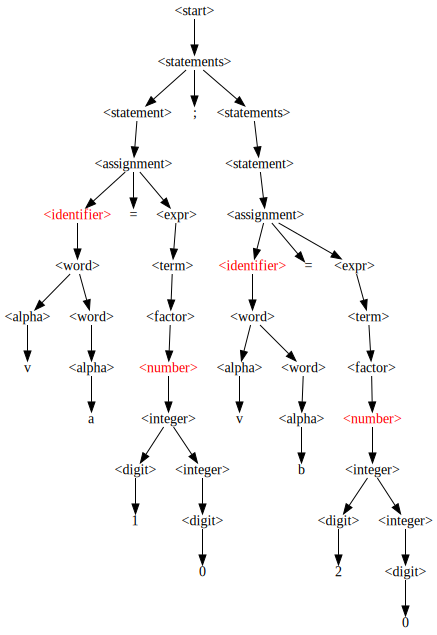

In [10]:
parser = PEGParser(VAR_GRAMMAR)
for tree in parser.parse(mystring):
    display_tree(tree, node_attr=highlight_node(hl_predicate))

As can be seen from the above example, our grammar is rather detailed. So we need to define our token nodes, which correspond to the *red* nodes above.

In [11]:
VAR_TOKENS = {'<number>', '<identifier>'}

These tokens are pruned using the `prune_tree` method that we mentioned previously.
Here is a slightly more complex program to parse, but with the tree pruned using tokens:

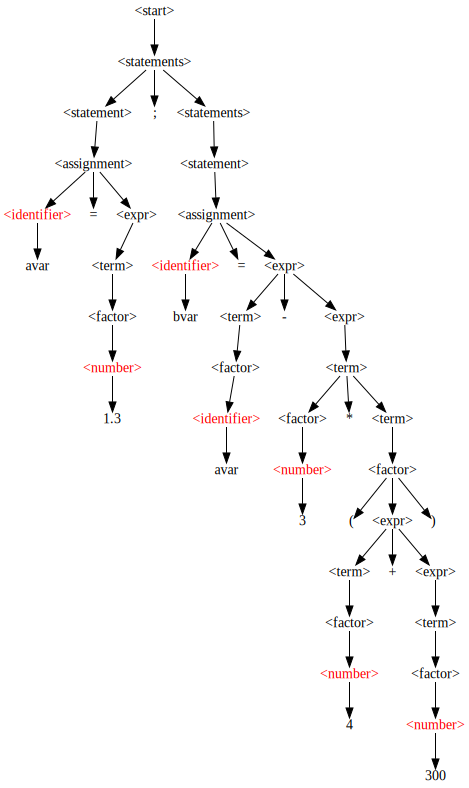

In [12]:
mystring = 'avar=1.3;bvar=avar-3*(4+300)'
parser = PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS)
for tree in parser.parse(mystring):
    display_tree(tree, node_attr=highlight_node(hl_predicate))

We develop a `LangFuzzer` class that generates recombined inputs. To apply the _Langfuzz_ approach, we need a few parsed strings.

In [13]:
mystrings = [
    'abc=12+(3+3.3)',
    'a=1;b=2;c=a+b',
    'avar=1.3;bvar=avar-3*(4+300)',
    'a=1.3;b=a-1*(4+3+(2/a))',
    'a=10;b=20;c=34;d=-b+(b*b-4*a*c)/(2*a)',
    'x=10;y=20;z=(x+y)*(x-y)',
    'x=23;y=51;z=x*x-y*y',
]

We recurse through any given tree, collecting parsed fragments corresponding to each nonterminal. Further, we also name each node so that we can address each node separately.

In [14]:
from Fuzzer import Fuzzer

In [15]:
class LangFuzzer(Fuzzer):
    def __init__(self, parser):
        self.parser = parser
        self.fragments = {k: [] for k in self.parser.cgrammar}

    def traverse_tree(self, node):
        counter = 1
        nodes = {}

        def helper(node, id):
            nonlocal counter
            name, children = node
            new_children = []
            nodes[id] = node
            for child in children:
                counter += 1
                new_children.append(helper(child, counter))
            return name, new_children, id

        return helper(node, counter), nodes

    def fragment(self, strings):
        self.trees = []
        for string in strings:
            for tree in self.parser.parse(string):
                tree, nodes = self.traverse_tree(tree)
                self.trees.append((tree, nodes))
                for node in nodes:
                    symbol = nodes[node][0]
                    if symbol in self.fragments:
                        self.fragments[symbol].append(nodes[node])
        return self.fragments

We thus obtain all valid fragments from our parsed strings.

In [16]:
lf = LangFuzzer(PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS))
fragments = lf.fragment(mystrings)
for key in fragments:
    print("%s: %d" % (key, len(fragments[key])))

<start>: 7
<statements>: 18
<statement>: 18
<assignment>: 18
<identifier>: 37
<word>: 0
<alpha>: 0
<expr>: 39
<term>: 50
<factor>: 51
<number>: 23
<integer>: 0
<digit>: 0


All that remains is to actually find a place to poke a hole using `candidate()`, and patch that hole using `generate_new_tree()`. We will explain how to do this next.

But before that, we update our `initialization` method with a call to `fragment().

In [17]:
import random

In [18]:
class LangFuzzer(LangFuzzer):
    def __init__(self, parser, strings):
        self.parser = parser
        self.fragments = {k: [] for k in self.parser.cgrammar}
        self.fragment(strings)

#### Candidate
`LangFuzzer` accepts a list of strings, which are stored as derivation trees in the object.

The method `candidate()` chooses one of the derivation trees randomly as the template, and identifies a node such that it can be replaced by another node that is different from itself. That is, it chooses a node such that, if the non-terminal name of the node is `node_type`, there is at least one other entry in `fragment[node_type])` 

In [19]:
class LangFuzzer(LangFuzzer):
    def candidate(self):
        tree, nodes = random.choice(self.trees)
        interesting_nodes = [
            n for n in nodes if nodes[n][0] in self.fragments
            and len(self.fragments[nodes[n][0]]) > 1
        ]
        node = random.choice(interesting_nodes)
        return tree, node

Here is how it is used -- the *red* node is the node chosen.

In [20]:
random.seed(1)
lf = LangFuzzer(PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS), mystrings)
tree, node = lf.candidate()

In [21]:
def hl_predicate(_d, nid, _s, _a): return nid in {node}

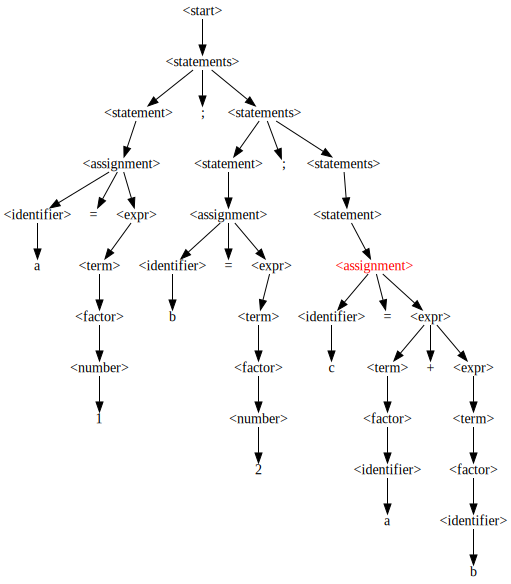

In [22]:
display_tree(tree, node_attr=highlight_node(hl_predicate))

#### Generate New Tree
Once we have identified the node, one can generate a new tree by replacing that node with another node of similar type from our fragment pool.

In [23]:
class LangFuzzer(LangFuzzer):
    def generate_new_tree(self, node, choice):
        name, children, id = node
        if id == choice:
            return random.choice(self.fragments[name])
        else:
            return (name, [self.generate_new_tree(c, choice)
                           for c in children])

Again, the red node indicates where the replacement has occurred.

In [24]:
random.seed(1)
lf = LangFuzzer(PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS), mystrings)
tree, node = lf.candidate()

In [25]:
def hl_predicate(_d, nid, _s, _a): return nid in {node}

In [26]:
from GrammarFuzzer import tree_to_string

a=1;b=2;c=a+b
a=1;b=2;b=2


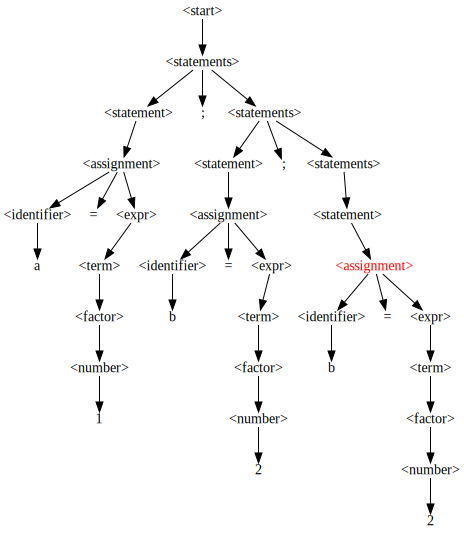

In [27]:
new_tree = lf.generate_new_tree(tree, node)
for s in [tree_to_string(i) for i in [tree, new_tree]]:
    print(s)
display_tree(new_tree, node_attr=highlight_node(hl_predicate))

#### Fuzz

The `fuzz()` method simply calls the procedures defined before in order.

In [28]:
class LangFuzzer(LangFuzzer):
    def fuzz(self):
        tree, node = self.candidate()
        modified = self.generate_new_tree(tree, node)
        return tree_to_string(modified)

Here is our fuzzer in action.

In [29]:
lf = LangFuzzer(PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS), mystrings)
for i in range(10):
    print(lf.fuzz())

x=23;bvar=avar-3*(4+300)
x=23;y=51;z=x*x-(x+y)*(x-y)
x=10;y=20;z=(1.3)*(x-y)
abc=12+(12+3.3)
x=23;y=51;z=y*x-y*y
a=10;b=20;c=34;d=-b+(b*b-4*y)/(2*a)
abc=12+((4+3+(2/a))+3.3)
x=10;y=20;z=(x+y)*(x-y)
abc=12+(3+3.3)
x=10;y=20;z=(x+y)*(x-y)


How effective was our fuzzing? Let us find out!

In [30]:
from Timer import Timer

In [31]:
trials = 100

lf = LangFuzzer(PEGParser(VAR_GRAMMAR, tokens=VAR_TOKENS), mystrings)
valid = []
time = 0
for i in range(trials):
    with Timer() as t:
        s = lf.fuzz()
        try:
            exec(s, {}, {})
            valid.append((s, t.elapsed_time()))
        except:
            pass
        time += t.elapsed_time()
print("%d valid strings, that is LangFuzzer generated %f%% valid entries" %
      (len(valid), len(valid) * 100.0 / trials))
print("Total time of %f seconds" % time)

61 valid strings, that is LangFuzzer generated 61.000000% valid entries
Total time of 0.011114 seconds


In [32]:
gf = GrammarFuzzer(VAR_GRAMMAR)
valid = []
time = 0
for i in range(trials):
    with Timer() as t:
        s = gf.fuzz()
        try:
            exec(s, {}, {})
            valid.append(s)
        except:
            pass
        time += t.elapsed_time()
print("%d valid strings, that is GrammarFuzzer generated %f%% valid entries" %
      (len(valid), len(valid) * 100.0 / trials))
print("Total time of %f seconds" % time)

4 valid strings, that is GrammarFuzzer generated 4.000000% valid entries
Total time of 1.366280 seconds


That is, our `LangFuzzer` is rather effective on generating valid entries when compared to the `GrammarFuzzer`.

## Grammar-Based Mutation

General idea: Take a derivation tree and a matching grammar; apply a random mutation.

In [33]:
from Grammars import EXPR_GRAMMAR
from GrammarFuzzer import display_tree
from Parser import EarleyParser

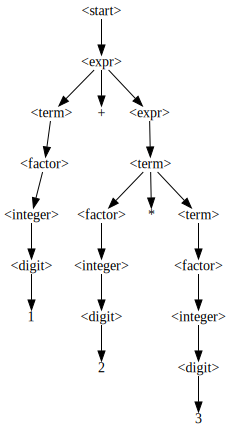

In [34]:
parser = EarleyParser(EXPR_GRAMMAR)
tree,*_ = parser.parse("1 + 2 * 3")
display_tree(tree)

1. Pick any node in the tree
2. Produce a new expansion.

We have seen this for `LangFuzzer` already, right?

How about we factor this out (from the Parser notebook), and have two notebook on mutational (and genetic fuzzing):

1. `LangFuzzer` – a chapter on
    * Mutating trees (randomly)
    * Mutating trees from a given population (the LangFuzz approach)
    * Tree recombination (and crossover)
    
2. `EvoGrammarFuzzer` – a chapter on
    * Genetic improvement (using coverage only)
    * Genetic improvement (using a fitness function from search-based fuzzing)

In [35]:
def mutate_tree(tree, grammar):
    pass

## Lessons Learned

* We can generate a pool of fragments using the _LangFuzz_ approach, and use it to generate nearly valid strings.

## Next Steps

* In the [chapter on evolutionary fuzzing](EvoGrammarFuzzer.ipynb), we discuss how to systematically evolve a population of inputs through mutation and crossover operations (as discussed in this chapter) to achieve a specific goal such as code coverage.

## Background

Recombining parsed inputs was pioneered by _Langfuzz_ \cite{Holler2012}, which also gave its name to the main class of this chapter.

## Exercises


### Exercise 1: A Different LangFuzzer

Sometimes we do not want to use our pool of strings for various reasons – the number of items in the pool may be inadequate, or not varied enough. Extend the `LangFuzzer` to use a separate function to check if the number of items in the pool corresponding to the selected non-terminal is large enough (say greater than 10), and if not, use the tree expansion technique from `GrammarFuzzer` to patch the hole.

**Solution.** Here is a possible solution.  Before we can make use of `GrammarFuzzer`, we need to change it a little bit. GrammarFuzzer relies on the grammar being in the `fuzzing` format with the expansions represented as strings. Our `LangFuzzer` expects the expansions to be a list of tokens. So we fix the output of `GrammarFuzzer`.

In [36]:
class LangFuzzer2(LangFuzzer):
    def __init__(self, parser, strings):
        super().__init__(parser, strings)
        self.gfuzz = GrammarFuzzer(parser.grammar())

    def check_diversity(self, pool):
        return len(pool) > 10

    def candidate(self):
        tree, nodes = random.choice(self.trees)
        interesting_nodes = [
            n for n in nodes if nodes[n][0] in self.fragments
            and nodes[n][0] is not self.parser.start_symbol()
            and len(self.fragments[nodes[n][0]]) > 0
        ]
        node = random.choice(interesting_nodes)
        return tree, node

    def generate_new_tree(self, node, choice):
        name, children, id = node
        if id == choice:
            pool = self.fragments[name]
            if self.check_diversity(pool):
                return random.choice(self.fragments[name])
            else:
                return None
        else:
            return (name,
                    [self.generate_new_tree(c, choice) for c in children])

    def fuzz(self):
        tree, node = self.candidate()
        tree_with_a_hole = self.generate_new_tree(tree, node)
        modified = self.gfuzz.expand_tree(tree_with_a_hole)
        return tree_to_string(modified)

In [37]:
parser = EarleyParser(VAR_GRAMMAR, tokens=VAR_TOKENS)
lf = LangFuzzer2(parser, mystrings)
for i in range(100):
    print(lf.fuzz())

a=1;b=2;b=2
a=1.3;b=a-1*b
a=1;b=2;c=4+300
a=1.3;b=a-1*(1.3+3+(2/a))
a=10;b=20;c=34;d=-b+(b*b-4*a*a)/(2*a)
bvar=avar-3*(4+300);y=51;z=x*x-y*y
a=10;b=20;c=34;d=-b+(b*b-4*a*c)/(x+y)
z=x*x-y*y;b=2;c=a+b
x=10;y=20;z=(x+y)*(a-y)
z=(x+y)*(x-y);y=20;z=(x+y)*(x-y)
x=23;y=51;z=x*x-3
x=a;y=51;z=x*x-y*y
a=10;b=20;c=34;d=-b+(b*x-4*a*c)/(2*a)
a=1;b=2;c=y+b
x=23;y=51;z=x*x-(2/a)
a=300;b=2;c=a+b
avar=1.3;a=1.3;b=a-1*(4+3+(2/a))
x=23;y=51;z=x*b-y*y
a=10;b=34;c=34;d=-b+(b*b-4*a*c)/(2*a)
a=1.3;b=a-1*(4+4*a*c+(2/a))
x=23;y=51;z=x*x-y*y
x=23;y=51;z=x*x-y*(x-y)
abc=12+(1.3+3.3)
a=10;b=20;c=34;d=-b+(b*b-1)/(2*a)
avar=1.3;bvar=avar-3*(4+300)
a=1;b=2;c=a+b
abc=12+(avar+3.3)
a=1;b=20;c=a+b
abc=12+(2+3.3)
avar=51;bvar=avar-3*(4+300)
avar=2;bvar=avar-3*(4+300)
x=10;b=20;c=34;d=-b+(b*b-4*a*c)/(2*a)
abc=12+(3*(4+300)+3.3)
a=10;b=20;c=34;d=-b+(b*b-4*a*c)/(4*a*c)
x=23;y=51;d=-b+(b*b-4*a*c)/(2*a)
a=1.3;b=4-1*(4+3+(2/a))
x=2;y=20;z=(x+y)*(x-y)
z=(x+y)*(x-y);b=20;c=34;d=-b+(b*b-4*a*c)/(2*a)
x=23;y=(2/a);z=x*x-y*y
b=2;c=

With these changes, our `LangFuzzer2` is able to use the pool of fragments when necessary, but can rely on the grammar when the pool is not sufficient.